In [1]:
import os
import sys
import numpy as np
from astropy.table import Table
from snlstm.AccessArchivalData import AccessDB
from snlstm.utils.GPLightCurve import PhotBVColor
from snlstm.SpecProc import HomogenizeSpec, CorrectSpec

#DBDir = '/path/to/your/database/directory'
DBDir = '/home/thomas/Lpackages/snlstm-db'  # FIXME
SNOBJ = AccessDB(SN_name='SN2002bo', DBDir=DBDir)

#### Retrieve the six spectra of SN 2002bo took at -2.0d to -1.0d (Raw & Homogenized & Corrected)

In [2]:
# ** Search the spectra by given phase range
SID_LST = SNOBJ.Search_SpecID(PhaseRange=(-2.0, -1.0), verbose=True)

# ** Retrieve the spectra (Raw & Homogenized & Correct)
SpecDICT = {}
for sid in SID_LST:
    AstSpecRaw = SNOBJ.Retrieve_SpecObs(Spec_ID=sid, data_type='Raw', deredshift_rawspec=True)
    AstSpecHomo = SNOBJ.Retrieve_SpecObs(Spec_ID=sid, data_type='Homogenized')
    AstSpecCorr = SNOBJ.Retrieve_SpecObs(Spec_ID=sid, data_type='Corrected')
    
    SpecDICT[(sid, 'Raw')] = {'wavelength': AstSpecRaw['wavelength'], 'flux': AstSpecRaw['flux']}
    SpecDICT[(sid, 'Homogenized')] = {'wavelength': AstSpecHomo['wavelength'], 'flux': AstSpecHomo['flux']}
    SpecDICT[(sid, 'Corrected')] = {'wavelength': AstSpecCorr['wavelength'], 'flux': AstSpecCorr['flux']}


Spec ID : 104545 (Phase : -1.81 d) (Tel / Inst : Ekar / AFOSC)
Spec ID : 104544 (Phase : -1.73 d) (Tel / Inst : NOT / ALFOSC)
Spec ID : 100446 (Phase : -1.53 d) (Tel / Inst : Lick-3m / KAST)
Spec ID : 21368 (Phase : -1.53 d) (Tel / Inst : Lick-3m / KAST)
Spec ID : 102321 (Phase : -1.52 d) (Tel / Inst : FLWO-1.5m / FAST)
Spec ID : 104546 (Phase : -1.51 d) (Tel / Inst : WHT-4.2m / ISIS)


#### Present data processes step by step from Raw > Homogenized > Corrected
- None: we take the spectrum 104546 at -1.51d (the green curve in the figure at the end) as example.

In [3]:
# ** Retrieve basic information about SN 2002bo
redshift = SNOBJ.SN_Attributes()['Redshift']
MJD_Bmax = SNOBJ.SN_Attributes()['MJD_Bmax']

# ** Retrieve phase about the spectrum (104546, -1.51d) 
sid_spec = 104546
phase_spec = SNOBJ.Spec_Attributes(Spec_ID=sid_spec)['Phase']

# ** Retrieve the Raw Spectrum
AstSpec_Raw = SNOBJ.Retrieve_SpecObs(Spec_ID=sid_spec, data_type='Raw', deredshift_rawspec=False)  # in obs-frame
Wave_Raw, Flux_Raw = np.array(AstSpec_Raw['wavelength']), np.array(AstSpec_Raw['flux'])  

# ** Homogenize the spectrum, using the module snlstm.SpecProc.HomogenizeSpec
HomoSpec_dict = HomogenizeSpec.HS(Wave_Raw=Wave_Raw, Flux_Raw=Flux_Raw, deredshift=True, redshift=redshift)
Wave_Homo, Flux_Homo = np.array(HomoSpec_dict['wavelength']), np.array(HomoSpec_dict['flux'])


In [4]:
# ** Retrieve B & V light curves of SN 2002bo
AstBVp = SNOBJ.Retrieve_BVphot()
AstBp = AstBVp[AstBVp['Passband'] == 'B(kait3)']
AstVp = AstBVp[AstBVp['Passband'] == 'V(kait3)']

MJD_B, MAG_B, eMAG_B = np.array(AstBp['MJD_OBS']), np.array(AstBp['MAG']), np.array(AstBp['eMAG'])
MJD_V, MAG_V, eMAG_V = np.array(AstVp['MJD_OBS']), np.array(AstVp['MAG']), np.array(AstVp['eMAG'])

# ** GP interpolation for B & V Photometry, using module snlstm.utils.GPLightCurve.PhotBVColor
#    this is to derive B-V magnitude at the observation time of the spectrum
BmV_tar = PhotBVColor(MJD_B, MAG_B, eMAG_B, MJD_V, MAG_V, eMAG_V, MJD_Bmax, redshift, [phase_spec])[0][0]
print('CheckPoint: The target B-V magnitude generated by GP-interpolation is %.3f mag' %BmV_tar)

# ** Perform spectral correction including color calibration, using the module snlstm.SpecProc.CorrectSpec
CorrSpec_dict = CorrectSpec.CS(Wave_Homo=Wave_Homo, Flux_Homo=Flux_Homo, phase=phase_spec, redshift=redshift, \
    T7605=False, T6869=True, Halpha=False, Hbeta=False, BmV_tar=BmV_tar, \
    filtname_B='B(kait3)', filtname_V='V(kait3)', phot_system='Vega')
Wave_Corr, Flux_Corr = np.array(CorrSpec_dict['wavelength']), np.array(CorrSpec_dict['flux'])


>>> B band: natural system with filter B(kait3)
    (find transmission curves at /home/thomas/miniconda3/envs/gspec/lib/python3.7/site-packages/snlstm-1.0.1-py3.7.egg/snlstm/utils/helper/transmission_curves/B(kait3).txt)
>>> V band: natural system with filter V(kait3)
    (find transmission curves at /home/thomas/miniconda3/envs/gspec/lib/python3.7/site-packages/snlstm-1.0.1-py3.7.egg/snlstm/utils/helper/transmission_curves/V(kait3).txt)
CheckPoint: Input Photometry [-14.3d - 42.3d] with [23] datapoints
CheckPoint: Input Photometry [-11.3d - 42.3d] with [23] datapoints
CheckPoint: The target B-V magnitude generated by GP-interpolation is 0.327 mag
CheckPoint: Spectral SyntheticPhot B-V magnitude offset [-0.033 mag]
CheckPoint: Spectral SyntheticPhot B-V magnitude [0.517 mag (input) >>> 0.327 mag (output)]


In [5]:
# * Verifiy the produced homogenized & corrected spectrum are consistent with the ones in out archival dataset
Flux_Homo_DB = np.array(SNOBJ.Retrieve_SpecObs(Spec_ID=sid_spec, data_type='Homogenized')['flux'])
Flux_Corr_DB = np.array(SNOBJ.Retrieve_SpecObs(Spec_ID=sid_spec, data_type='Corrected')['flux'])

print('Homogenized spectrum is consistent with archival dataset: [%s]' %(np.allclose(Flux_Homo, Flux_Homo_DB)))
print('Corrected spectrum is consistent with archival dataset: [%s]' %(np.allclose(Flux_Corr, Flux_Corr_DB)))


Homogenized spectrum is consistent with archival dataset: [True]
Corrected spectrum is consistent with archival dataset: [True]


### Figure: Show the six spectra of SN 2002bo took at -2.0d to -1.0d (Raw & Homogenized & Corrected)

<IPython.core.display.Javascript object>


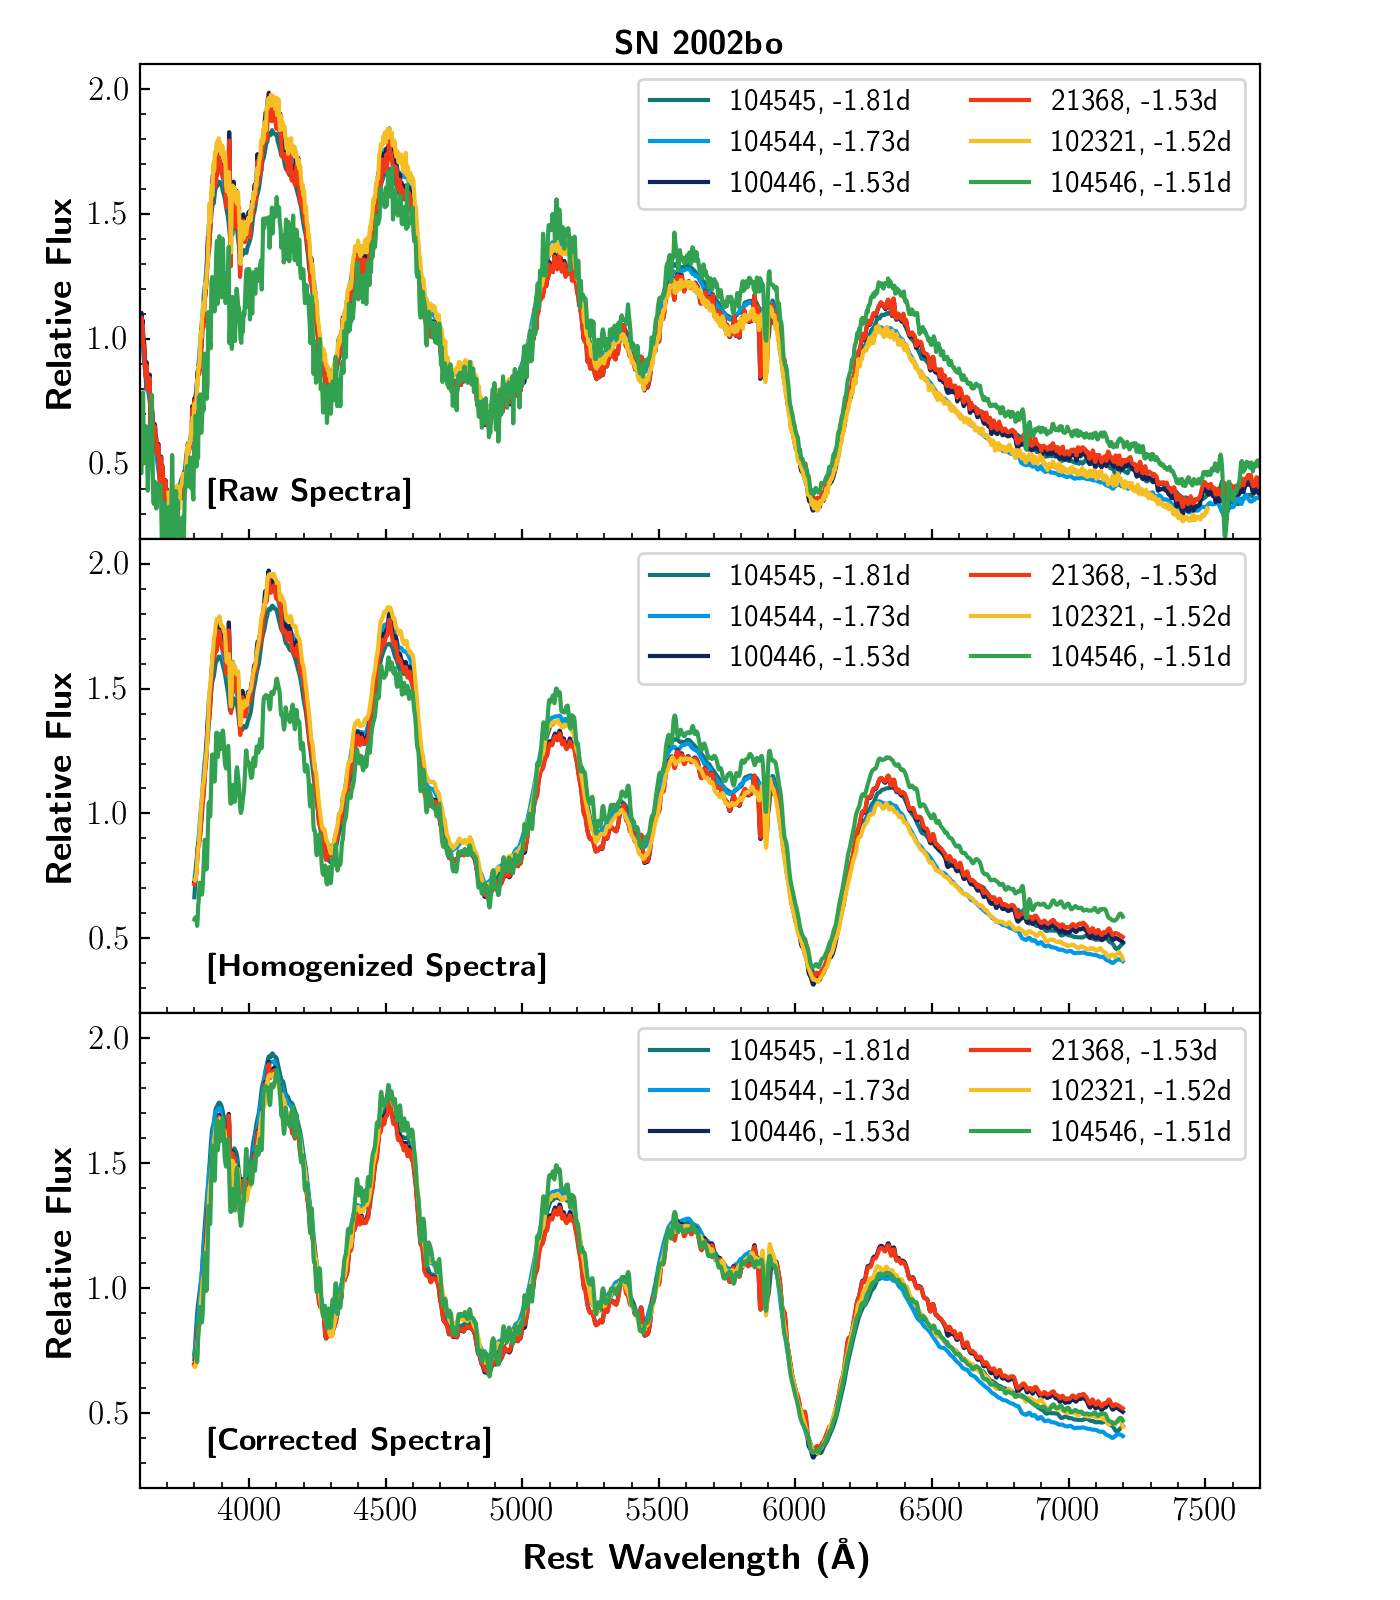

In [7]:
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
matplotlib.rc('text', usetex=True)

%matplotlib nbagg
fig = plt.figure(figsize=(7, 8))
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
fig.subplots_adjust(hspace=0.0, wspace=0.0, left=0.1, right=0.9, bottom=0.07, top=0.96)
COLORSEQ = ['#127576', '#0099E6', '#12255A', '#F23814', '#F5BE25', '#32A251']

axU = plt.subplot(311)
for idx, sid in enumerate(SID_LST):
    Wave_Raw = np.array(SpecDICT[(sid, 'Raw')]['wavelength'])
    Flux_Raw = np.array(SpecDICT[(sid, 'Raw')]['flux'])
    normal_factor = np.mean(Flux_Raw[np.logical_and(Wave_Raw >= 3800, Wave_Raw <= 7200)]) 
    phase = SNOBJ.Spec_Attributes(Spec_ID=sid)['Phase']
    axU.plot(Wave_Raw, Flux_Raw/normal_factor, '-', linewidth=1.5, \
        label='%d, %.2fd' %(sid, phase), color=COLORSEQ[idx])

axU.annotate(r'\textbf{[Raw Spectra]}', xy=(3850, 0.35), fontsize=11.5, color='black')
axU.tick_params(top=False, bottom=True, left=True, right=False, \
    labelleft=True, labelright=False, labelbottom=False, labeltop=False)

axU.xaxis.set_minor_locator(MultipleLocator(100))
axU.xaxis.set_major_locator(MultipleLocator(500))
axU.yaxis.set_minor_locator(MultipleLocator(0.1))
axU.yaxis.set_major_locator(MultipleLocator(0.5))

#axU.set_xlabel(r'\textbf{Rest Wavelength (\AA)}', fontsize=13)
axU.set_ylabel(r'\textbf{Relative Flux}', fontsize=13)
plt.setp(axU.get_xticklabels(), fontsize=12)
plt.setp(axU.get_yticklabels(), fontsize=12)
axU.set_xlim(3601, 7700)
axU.set_ylim(0.2, 2.1)
axU.legend(fontsize=10.5, ncol=2)

axM = plt.subplot(312)
for idx, sid in enumerate(SID_LST):
    Wave_Homo = np.array(SpecDICT[(sid, 'Homogenized')]['wavelength'])
    Flux_Homo = np.array(SpecDICT[(sid, 'Homogenized')]['flux'])
    phase = SNOBJ.Spec_Attributes(Spec_ID=sid)['Phase']
    axM.plot(Wave_Homo, Flux_Homo, '-', linewidth=1.5, \
        label='%d, %.2fd' %(sid, phase), color=COLORSEQ[idx])

axM.annotate(r'\textbf{[Homogenized Spectra]}', xy=(3850, 0.35), fontsize=11.5, color='black')
axM.tick_params(top=False, bottom=True, left=True, right=False, \
    labelleft=True, labelright=False, labelbottom=False, labeltop=False)

axM.xaxis.set_minor_locator(MultipleLocator(100))
axM.xaxis.set_major_locator(MultipleLocator(500))
axM.yaxis.set_minor_locator(MultipleLocator(0.1))
axM.yaxis.set_major_locator(MultipleLocator(0.5))

axM.set_xlabel(r'\textbf{Rest Wavelength (\AA)}', fontsize=13)
axM.set_ylabel(r'\textbf{Relative Flux}', fontsize=13)
plt.setp(axM.get_xticklabels(), fontsize=12)
plt.setp(axM.get_yticklabels(), fontsize=12)
axM.set_xlim(3601, 7700)
axM.set_ylim(0.2, 2.1)
axM.legend(fontsize=10.5, ncol=2)

axL = plt.subplot(313)
for idx, sid in enumerate(SID_LST):
    Wave_Corr = np.array(SpecDICT[(sid, 'Corrected')]['wavelength'])
    Flux_Corr = np.array(SpecDICT[(sid, 'Corrected')]['flux'])
    phase = SNOBJ.Spec_Attributes(Spec_ID=sid)['Phase']
    axL.plot(Wave_Corr, Flux_Corr, '-', linewidth=1.5, \
        label='%d, %.2fd' %(sid, phase), color=COLORSEQ[idx])

axL.annotate(r'\textbf{[Corrected Spectra]}', xy=(3850, 0.35), fontsize=11.5, color='black')
axL.tick_params(top=False, bottom=True, left=True, right=False, \
    labelleft=True, labelright=False, labelbottom=True, labeltop=False)

axL.xaxis.set_minor_locator(MultipleLocator(100))
axL.xaxis.set_major_locator(MultipleLocator(500))
axL.yaxis.set_minor_locator(MultipleLocator(0.1))
axL.yaxis.set_major_locator(MultipleLocator(0.5))

axL.set_xlabel(r'\textbf{Rest Wavelength (\AA)}', fontsize=13)
axL.set_ylabel(r'\textbf{Relative Flux}', fontsize=13)
plt.setp(axL.get_xticklabels(), fontsize=12)
plt.setp(axL.get_yticklabels(), fontsize=12)
axL.set_xlim(3601, 7700)
axL.set_ylim(0.2, 2.1)
axL.legend(fontsize=10.5, ncol=2)

plt.suptitle(r'\textbf{SN 2002bo}')
plt.show()
